## Challenge 14: MongoDB Challenges

In [1]:
import pickle
import codecs
import string
import math

import pymongo
from bson.code import Code

import pprint

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
pymongo.version

'3.4.0'

In [3]:
client = pymongo.MongoClient('localhost', 27017)

In [4]:
client.database_names()

[u'admin', u'legislation', u'local', u'metal_movies_db']

In [5]:
client.drop_database('metal_movies_db')

### Setup

Make sure that mongodb is setup and the database server (`mongod`) is running.

We are going to work with reviews of Heavy Metal movies. Hellz Yeah. Unzip and unpickle the following file:

[heavy_metal_parsed.pkl.zip](https://github.com/thisismetis/chi17_ds1/blob/master/challenges/challenges_questions/14-mongo_twitter/heavy_metal_parsed.pkl.zip)

In [6]:
with open('data/heavy_metal_parsed.pkl', 'r') as datafile:
    heavy_metal_reviews = pickle.load(datafile)

In [7]:
first_review = heavy_metal_reviews[0]
first_review.keys()

['head',
 'metal_cred',
 'title',
 'direct',
 'solid_metal_nuggets',
 'cast',
 'raw',
 'the_meat',
 'year',
 'sections']

In [8]:
for line in first_review['raw']:
    print line

200 MOTELS (1971)
DIRECTORS: Tony Palmer, Frank Zappa
CAST: Frank Zappa, Ringo Starr, Mark Volman, Howard Kaylan, Keith
Moon
METAL CRED
Frank Zappa
Nun Desecration
THE MEAT
Beyond his metal sainthood for
battling the censor-witches of the PMRC and getting named checked by Deep
Purple in “Smoke on the Water”, musical visionary Frank Zappa led many rock
fans to heavy metal.
And, from there, he led many metal
fans to the outer expanses of rock’s possibilities.
Zappa also opened countless banging
heads to the far reaches of jazz, classical, doo-wop, and any other art form
that could involve (brilliant) noise and (brilliantly dumb) dirty jokes.
200
Motels is Zappa’s first crack at major motion picture madness, and it
embodies the much forgotten cultural moment when acid rock tumbled forever into
the black pits of rising heavy metal.
Surrealistic sketches and
psychedelic set pieces about the insanity of a being on tour are interspersed
among performances in which the Mothers jam with London 

In [9]:
#create metal movies mongodb
db = client.metal_movies_db

In [10]:
#create reviews collection (rc)
rc = db.rc

In [11]:
#add all reviews to rc
for review in heavy_metal_reviews:
    rc.insert_one(review)

In [12]:
rc.count()

856

In [13]:
db.collection_names()

[u'rc']

## Challenge 1

Make a histogram of the years in the data. How many metal movies came out over the years?

In [81]:
rc.find_one().keys()

[u'raw',
 u'head',
 u'metal_cred',
 u'title',
 u'metal_score',
 u'direct',
 u'solid_metal_nuggets',
 u'cast',
 u'the_meat',
 u'year',
 u'_id',
 u'sections']

### _Dictionaries_

In [15]:
years = {}
for movie in rc.find():
    year = movie['year']
    years[year] = years.get(year, 0) + 1

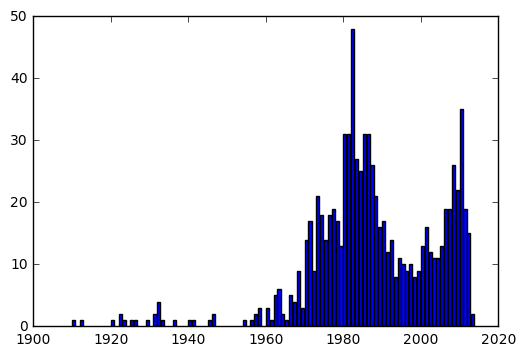

In [16]:
plt.bar(years.keys(), years.values());

### _pymongo_

In [18]:
pipe = [{'$group': {'_id': '$year',
                    'num_movies': {'$sum': 1}}}]
pprint.pprint(list(rc.aggregate(pipeline=pipe))[:3])

[{u'_id': 1956, u'num_movies': 1},
 {u'_id': 1923, u'num_movies': 1},
 {u'_id': 1929, u'num_movies': 1}]


In [19]:
years=[]
num_movies=[]
for item in list(rc.aggregate(pipeline=pipe)):
    years.append(item['_id'])
    num_movies.append(item['num_movies'])

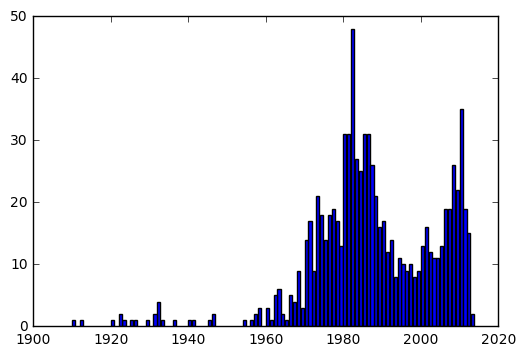

In [20]:
plt.bar(years, num_movies);

## Challenge 2

Find the cast member that appeared in most Heavy Metal movies. Is there one that is shared by more than one of these movies? Or are they all completely different actors for every movie?

### _Dictionaries_

In [21]:
actors = {}
for movie in rc.find():
    for actor in movie['cast']:
        if actor:
            actor = actor.encode('utf-8')
            actors[actor] = actors.get(actor, 0) + 1

In [22]:
top_actor = max(actors.iterkeys(), key=(lambda key: actors[key]))
print top_actor, actors[top_actor]

Alice Cooper 15


### _pymongo_

In [23]:
pipe = [
    {'$unwind': '$cast'},
    {'$group': {'_id': '$cast',
                    'num_movies': {'$sum': 1}}}
]
pprint.pprint(list(rc.aggregate(pipeline=pipe))[:3])

[{u'_id': u'John Mills', u'num_movies': 1},
 {u'_id': u'Richard Widmark', u'num_movies': 1},
 {u'_id': u'Nastassja Kinsi', u'num_movies': 1}]


In [24]:
pipe = [
    {'$project': {'_id': 0, 'cast': 1}},
    {'$match': {'cast': {'$exists': True,
                        '$ne': ''}}},
    {'$unwind': '$cast'},
    {'$group': {'_id': '$cast',
                'num_movies': {'$sum': 1}}},
    {'$sort': {'num_movies': -1}}
]
pprint.pprint(list(rc.aggregate(pipeline=pipe))[0])

{u'_id': u'Alice Cooper', u'num_movies': 15}


## Challenge 3

Find the most used words in Heavy Metal film titles. Is there a word that appears in a lot of them? Is it "The"? If it is something like "the", how can you get around that? Find one "meaningful" word that appears the most (this means non-structural word, unlike "the" or "a" or "in")

### _Dictionaries_

In [25]:
title_words = {}
for movie in rc.find():
    title = movie['title']
    #print type(title)
    title = title.encode('utf-8')
    #print type(title)
    
    #drop posessives, then remove punctuation
    title = title.replace("\xe2\x80\x99S", '')
    #title = title.replace("'S", "") #why doesn't this work?
    title = title.translate(None, string.punctuation)
    #print title
    
    #words = title.encode('utf-8').split()
    words = title.split()
    for word in words:
        if len(word) > 3:
            title_words[word] = title_words.get(word, 0) + 1

In [26]:
top_5_title_words = sorted(title_words, key=title_words.get, reverse=True)[:5]
for key in top_5_title_words:
    print key, title_words[key]

METAL 36
DEAD 24
HEAVY 19
ROCK 19
DEVIL 16


### _pymongo_

In [27]:
map = Code(" function() {"
    "var title = this.title;"
    "words = title.toUpperCase().match(/[A-Z]+/gi);"
    "if (words) {"
       " for (var i = words.length - 1; i >= 0; i--) {"
         "   if (words[i])  {"
          "     emit(words[i], 1);"
            "}"
        "}"
    "}"
"};")

In [28]:
reduce = Code ("function( key, values ) {" 
    "var count = 0;"
    "values.forEach(function(v) {"
        "count +=v;"
    "});"
    "return count;"
"}")

In [29]:
results = rc.map_reduce(map, reduce, 'word_count')

In [30]:
pipe = [
    {'$sort': {'value': -1}}
]
pprint.pprint(list(results.aggregate(pipeline=pipe))[:15])

[{u'_id': u'THE', u'value': 325.0},
 {u'_id': u'OF', u'value': 147.0},
 {u'_id': u'A', u'value': 36.0},
 {u'_id': u'METAL', u'value': 36.0},
 {u'_id': u'S', u'value': 29.0},
 {u'_id': u'AND', u'value': 28.0},
 {u'_id': u'IN', u'value': 25.0},
 {u'_id': u'DEAD', u'value': 24.0},
 {u'_id': u'ROCK', u'value': 21.0},
 {u'_id': u'HEAVY', u'value': 19.0},
 {u'_id': u'TO', u'value': 17.0},
 {u'_id': u'DEVIL', u'value': 16.0},
 {u'_id': u'BLACK', u'value': 14.0},
 {u'_id': u'BLOOD', u'value': 14.0},
 {u'_id': u'LAST', u'value': 13.0}]


## Challenge 4

METAL CRED section lists themes included in these movies that makes them more metal. What were the top 5 metal cred keywords in the 70s? In 80s? In 90s, In 2000s?

In [31]:
rc.find().next().keys()

[u'raw',
 u'head',
 u'metal_cred',
 u'title',
 u'direct',
 u'solid_metal_nuggets',
 u'cast',
 u'the_meat',
 u'year',
 u'_id',
 u'sections']

### _Dictionaries_

In [32]:
metal_cred_by_year = {}
for movie in rc.find({}, {'year': 1, 'metal_cred': 1}):
    metal_creds = movie['metal_cred']
    year = movie['year']
    for metal_cred in metal_creds[1:]:
        metal_cred_by_year[year] = metal_cred_by_year.get(year, {})
        metal_cred_by_year[year][metal_cred] = metal_cred_by_year[year].get(metal_cred, 0) + 1

In [33]:
metal_cred_by_decade = {}
for movie in rc.find({}, {'year': 1, 'metal_cred': 1}):
    metal_creds = movie['metal_cred']
    decade = str(movie['year'])[:3] + '0'
    for metal_cred in metal_creds[1:]:
        metal_cred = metal_cred.encode('utf-8')
        metal_cred_by_decade[decade] = metal_cred_by_decade.get(decade, {})
        metal_cred_by_decade[decade][metal_cred] = metal_cred_by_decade[decade].get(metal_cred, 0) + 1

In [34]:
for decade in ['1970', '1980', '1990', '2000']:
    print decade
    top_5_metal_creds = sorted(metal_cred_by_decade[decade], key=metal_cred_by_decade[decade].get, reverse=True)[:5]
    print top_5_metal_creds

1970
['Satan', 'Black Mass', 'Video Nasty', 'Post-Apocalypse', 'Zombies']
1980
['Post-Apocalypse', 'Sword and Sorcery', 'Satan', 'Video Nasty', '\xe2\x80\x9980s Italian Horror']
1990
['Satan', 'Gwar', 'Post-Apocalypse', 'Lemmy', 'Iggy Pop']
2000
['Torture Porn', 'Satan', 'Music Score: Charlie Clouser', 'Censorship', 'Billy Puppet']


### _pymongo_

In [1]:
pipe = [
    {'$match': {'year': {'$exists': True,
                            '$ne': ''}}},
    {'$project': {'_id': 0, 'decade': {'$multiply': [10, {'$floor': {'$divide': ['$year', 10]}}]}, 'metal_cred': 1}},
    {'$unwind': '$metal_cred'},
    {'$match': {'metal_cred': {'$ne': 'METAL CRED'}}},
    {'$group': {'_id' : {'decade': '$decade',
                         'metal_cred': '$metal_cred'},
                'count': {'$sum': 1}}},
    {'$group': {'_id': '$_id.decade',
               'metal_creds' : {'$push' : {'metal_cred': '$_id.metal_cred',
                                           'count': '$count'}}}},
    {'$match': {'_id': {'$gte': 1970}}},
    {'$sort': {'_id': 1, 'metal_creds.count': -1}} 
]
pprint.pprint(list(rc.aggregate(pipeline=pipe)))

NameError: name 'pprint' is not defined

### Challenge 5

Let's use the length of the METAL CRED section as a proxy score for how metal a movie is. Let's call this the METAL SCORE. To each mongo document, add the metal_score as a new field.

In [80]:
rc.find().next().keys()

[u'raw',
 u'head',
 u'metal_cred',
 u'title',
 u'metal_score',
 u'direct',
 u'solid_metal_nuggets',
 u'cast',
 u'the_meat',
 u'year',
 u'_id',
 u'sections']

### _Dictionaries_

In [36]:
for movie in rc.find():
    _id = movie['_id']
    metal_score = len(movie['metal_cred'])
    rc.update_one({'_id': _id},
             {'$set' : {'metal_score': metal_score}})

### _pymongo_

In [37]:
pipe = [
    {'$project': {'_id': '$_id', 'metal_score': { '$size':"$metal_cred" }}}
]
results = rc.aggregate(pipeline=pipe)

In [38]:
for result in results:
    rc.update_one({'_id': result['_id']}, {'$set': {'metal_score': result['metal_score']}})

In [39]:
rc.find_one()['metal_score']

3

## Challenge 6

Find the director that is MOST METAL per movie (director with the highest average metal score). Remember that some movies have multiple directors.

### _Dictionaries_

In [41]:
director_scores = {}
for movie in rc.find():
    directors = movie['direct']
    metal_score = movie['metal_score']
    for director in directors:
        director = director.encode('utf-8').upper()
        if director:
            director_scores[director] = director_scores.get(director, {})
            director_scores[director]['tot_metal_score'] = director_scores[director].get('tot_metal_score', 0) + metal_score
            director_scores[director]['num_movies'] = director_scores[director].get('num_movies', 0) + 1

In [42]:
for director in director_scores:
    tot_metal_score = director_scores[director]['tot_metal_score']
    num_movies = director_scores[director]['num_movies']
    avg_metal_score = tot_metal_score/num_movies
    director_scores[director]['avg_metal_score'] = avg_metal_score

In [79]:
sort = sorted(director_scores, key=director_scores.get, reverse=True)[:1]
for director in sort:
    print director, director_scores[director]

 JOHN MILIUS {'avg_metal_score': 75, 'tot_metal_score': 75, 'num_movies': 1}


### _pymongo_

In [73]:
pipe = [
    {'$match': {'direct': {'$exists': True,
                            '$ne': ''}}},
    {'$project': {'_id': 0, 'direct': 1, 'metal_score': 1}},
    {'$unwind': '$direct'},
    {'$group': {'_id': '$direct',
                'avg_metal_score': {'$avg': '$metal_score'},
               'num_movies': {'$sum': 1},
               'total_metal_score': {'$sum': '$metal_score'}}},
    {'$sort': {'avg_metal_score': -1}}
]
pprint.pprint(list(rc.aggregate(pipeline=pipe))[0])

{u'_id': u'John Milius',
 u'avg_metal_score': 75.0,
 u'num_movies': 1,
 u'total_metal_score': 75}


## Challenge 7

The majority of directors and actors will have worked on a single movie. See if there are any directors that worked with an actor more than once. If so, find the director-actor duo that have worked together the most times.

### _Dictionaries_

In [50]:
rc.find_one()['cast']

[u'Frank Zappa',
 u'Ringo Starr',
 u'Mark Volman',
 u'Howard Kaylan',
 u'Keith Moon']

In [51]:
rc.find_one()['direct']

[u'Tony Palmer', u'Frank Zappa']

In [52]:
directors_actors = {}
for movie in rc.find():
    directors = movie['direct']
    actors = movie['cast']
    for director in directors:
        director = director.encode('utf-8').upper()
        if director:
            directors_actors[director] = directors_actors.get(director, {})
            for actor in actors:
                actor = actor.encode('utf-8').upper()
                if actor:
                    directors_actors[director][actor] = directors_actors[director].get(actor, 0) + 1

In [53]:
for director, actors in directors_actors.items():
    for actor, appearances in actors.items():
        if appearances > 1:
            print director, '&', actor, ':', appearances

FRANK LALOGGIA & ELIZABETH HOFFMAN : 2
FRANK LALOGGIA & KATHLEEN ROWE MCALLEN : 2
FRANK LALOGGIA & STEFAN ANGRIM : 2
DARIO ARGENTO & ASIA ARGENTO : 2
DARIO ARGENTO & DARIA NICOLODI : 4
BRET MICHAELS & BRET MICHAELS : 2
BRET MICHAELS & CHARLIE SHEEN : 2
BRET MICHAELS & MARTIN SHEEN : 2
JOSEPH ZITO & CHUCK NORRIS : 2
ROB ZOMBIE & SHERI MOON ZOMBIE : 4
ROB ZOMBIE & SID HAIG : 2
ROB ZOMBIE & WILLIAM FORSYTHE : 2
JOE MASSOT & JOHN PAUL JONES : 2
JOE MASSOT & JOHN BONHAM : 2
JOE MASSOT & JIMMY PAGE : 2
JOE MASSOT & ROBERT PLANT : 2
JULES BASS & ORSON BEAN : 2
JULES BASS & BROTHER THEODORE : 2
VARIOUS & RICK SULLIVAN : 2
VARIOUS & GWAR : 2
VARIOUS & LINNEA QUIGLEY : 2
VARIOUS & MICHAEL BERRYMAN : 2
RALPH BAKSHI & SUSAN TYRELL : 2
JIM VAN BEBBER & PHIL ANSELMO : 2
JIM VAN BEBBER & JIM VAN BEBBER : 2
JOHN CARPENTER & JAMIE LEE CURTIS : 2
JOHN CARPENTER & DONALD PLEASANCE : 2
JOHN CARPENTER & ADRIENNE BARBEAU : 2
JOHN CARPENTER & KURT RUSSELL : 2
ARTHUR RANKIN JR. & ORSON BEAN : 2
ARTHUR RANKIN 

In [54]:
max_appearances = 0
for director, actors in directors_actors.items():
    for actor, appearances in actors.items():
        if appearances > max_appearances:
            max_appearances = appearances
print 'These directors and actors have worked together the most,', max_appearances, 'times:'

for director, actors in directors_actors.items():
    for actor, appearances in actors.items():
        if appearances == max_appearances:
            print director, '&', actor

These directors and actors have worked together the most, 4 times:
DARIO ARGENTO & DARIA NICOLODI
ROB ZOMBIE & SHERI MOON ZOMBIE
JOE D’AMATO & GEORGE EASTMAN
PETER JACKSON & CHRISTOPHER LEE


### _pymongo_

The majority of directors and actors will have worked on a single movie. See if there are any directors that worked with an actor more than once. If so, find the director-actor duo that have worked together the most times.

In [63]:
pipe = [
    {'$project': {'_id': 0, 'direct': 1, 'cast': 1}},
    {'$unwind': '$direct'},
    {'$unwind': '$cast'},
    {'$group': {'_id' : {'direct': '$direct',
                         'actor': '$cast'},
                'num_movies': {'$sum': 1}}},
    {'$sort': {'num_movies': -1}}
]
pprint.pprint(list(rc.aggregate(pipeline=pipe))[:5])

[{u'_id': {u'actor': u'Christopher Lee', u'direct': u'Peter Jackson'},
  u'num_movies': 4},
 {u'_id': {u'actor': u'George Eastman', u'direct': u'Joe D\u2019Amato'},
  u'num_movies': 4},
 {u'_id': {u'actor': u'Daria Nicolodi', u'direct': u'Dario Argento'},
  u'num_movies': 4},
 {u'_id': {u'actor': u'Sheri Moon Zombie', u'direct': u'Rob Zombie'},
  u'num_movies': 4},
 {u'_id': {u'actor': u'Damien Echols', u'direct': u'Bruce Sinofsky'},
  u'num_movies': 3}]


## Challenge 8

Create an index on the 'director' field to make the queries involving it faster.

In [82]:
rc.find_one().keys()

[u'raw',
 u'head',
 u'metal_cred',
 u'title',
 u'metal_score',
 u'direct',
 u'solid_metal_nuggets',
 u'cast',
 u'the_meat',
 u'year',
 u'_id',
 u'sections']

In [83]:
rc.create_index([('direct', pymongo.ASCENDING)], name='dir_index')

'dir_index'

In [84]:
db.rc.index_information()

{u'_id_': {u'key': [(u'_id', 1)], u'ns': u'metal_movies_db.rc', u'v': 2},
 u'dir_index': {u'key': [(u'direct', 1)],
  u'ns': u'metal_movies_db.rc',
  u'v': 2}}

## Challenge 9

For each decade, make a histogram of metal scores. Also, calculate the average metal score for each decade. Which decade was the most pure metal decade?